# Updated Mel Spectrogram encoding, relying more on librosa

~~combining all the code into a single function~~

add a flip to the filter banks (this would replicate the paper better?)

In [1]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import random
import pandas as pd
import re
from tqdm import trange
import copy

import scipy.io.wavfile
from scipy.fftpack import dct

In [2]:
# to get to HD
cache_dir=os.path.expanduser("~/data")

os.chdir(cache_dir)

# create new directory for raw HD
assert os.path.isdir("rawHD") == True
    
os.chdir("rawHD/hd_audio/audio")
print("current cwd", os.getcwd())

print(len(os.listdir()))

current cwd /its/home/ts468/data/rawHD/hd_audio/audio
10420


In [3]:
cd = os.listdir()

sample_file = cd[random.randint(0, len(os.listdir()))]

print(sample_file)

# load audio file to be played
ipd.Audio(sample_file)

lang-german_speaker-02_trial-13_digit-6.flac


In [4]:
def to_mel_spectrogram(file_name, display = False):
    
    audio, sr = librosa.load(file_name, sr = 20510, mono=True)
    
    # Apply pre-emphasis filter
    pre_emphasis = 0.95
    emphasized_audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

    # Define frame length and stride in samples
    frame_length = int(sr * 0.025)  # 25ms
    hop_length = int(sr * 0.01)  # 10ms

    # Compute the power spectrum using a 512-point FFT
    fft_size = 512 #TODO: work out why this is requiring a 1024-point FFT instead of a 512-point FFT
    power_spectrum = np.abs(librosa.stft(emphasized_audio, n_fft=fft_size, hop_length=hop_length, win_length=frame_length))**2

    # Compute the filter banks with 40 triangular filters
    num_bands = 40
    filter_banks = librosa.filters.mel(n_fft = fft_size, sr = sr, n_mels=num_bands)

    # Apply the filter banks to the power spectrum
    mel_spec = np.dot(filter_banks, power_spectrum)

    # Crop or pad to 80 steps by repeating the last frame
    target_steps = 80
    current_steps = mel_spec.shape[1]
    if current_steps < target_steps:
        padding = np.tile(mel_spec[:, -1:], (1, target_steps - current_steps))
        mel_spec = np.hstack((mel_spec, padding))
    elif current_steps > target_steps:
        mel_spec = mel_spec[:, :target_steps]

    # Convert power spectrogram to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if display:
        # Display the filter banks with the 'viridis' colormap
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Filter Banks with Pre-Emphasis Filter (Cropped/Padded to 80 Steps)')
        plt.tight_layout()
        plt.show()
        
        print(mel_spec_db.shape)
    
    else:
        return mel_spec_db

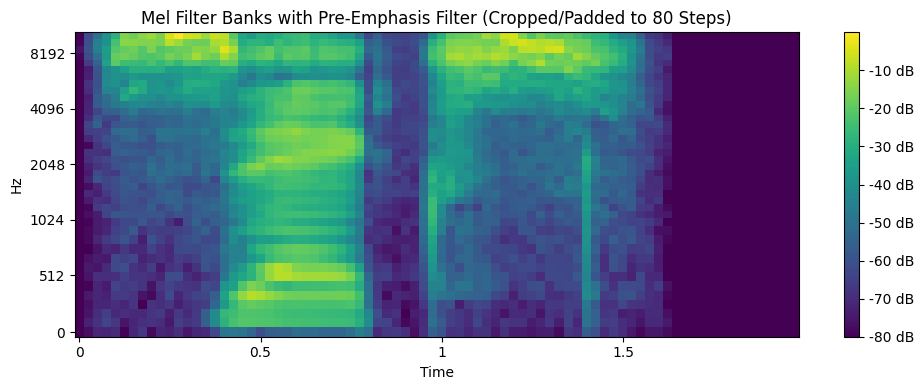

(40, 80)


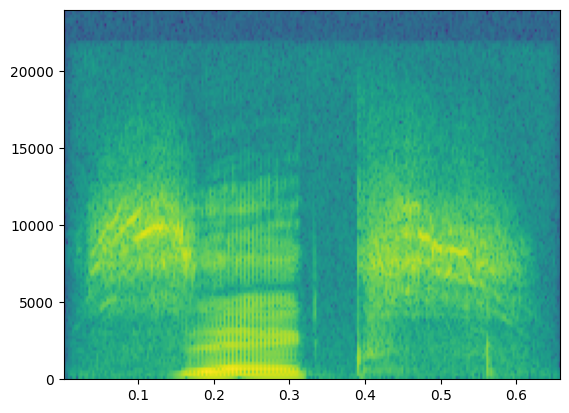

In [7]:
random_file = cd[random.randint(0, len(os.listdir()))]

to_mel_spectrogram(random_file, True)

import soundfile as sf

file_in_directory = random_file

data, samplerate = sf.read(file_in_directory)  

Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)


plt.show()

In [6]:
# load a list of training audio files
train_files = []
with open("/its/home/ts468/data/rawHD/hd_audio/train_filenames.txt", "r") as file:
    for line in file:
        x = line[:-1]
        train_files.append(x)
        
# load a list of testing audio files
test_files = []
with open("/its/home/ts468/data/rawHD/hd_audio/test_filenames.txt", "r") as file:
    for line in file:
        x = line[:-1]
        test_files.append(x)

In [8]:
training_x_data = []
training_y_data = []
testing_x_data = []
testing_y_data = []

training_details = pd.DataFrame({'Language': [], 
                                 'Speaker': [], 
                                 'Trial': [], 
                                 'Label': [],
                                 'classification label': []})

testing_details = pd.DataFrame({'Language': [], 
                                 'Speaker': [], 
                                 'Trial': [], 
                                 'Label': [],
                                 'classification label': []})

# save all to a list
for i in trange(len(os.listdir())):
    split_values = re.split("[. _ -]", os.listdir()[i])
    
    if os.listdir()[i] in train_files:
        training_x_data.append(copy.deepcopy(to_mel_spectrogram(os.listdir()[i])))
        training_y_data.append(int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)
        training_details.loc[len(training_details)] = {'Language': split_values[1], 
                                                       'Speaker': int(split_values[3]), 
                                                       'Trial': int(split_values[5]), 
                                                       'Label': int(split_values[7]),
                                                       'classification label': (int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)}
    else:
        testing_x_data.append(copy.deepcopy(to_mel_spectrogram(os.listdir()[i])))
        testing_y_data.append(int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)
        testing_details.loc[len(testing_details)] = {'Language': split_values[1], 
                                                     'Speaker': int(split_values[3]), 
                                                     'Trial': int(split_values[5]), 
                                                     'Label': int(split_values[7]),
                                                     'classification label': (int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)}

100%|██████████| 10420/10420 [05:20<00:00, 32.51it/s]


# Save dataset


In [9]:
# to get to HD
cache_dir=os.path.expanduser("~/data")

os.chdir(cache_dir)

# create new directory for raw HD
assert os.path.isdir("rawHD") == True    
os.chdir("rawHD/experimental_2/")
print("current cwd", os.getcwd())

current cwd /its/home/ts468/data/rawHD/experimental_2


In [10]:
len(training_x_data[0][0])

80

In [11]:
training_details.head()

,Language,Speaker,Trial,Label,classification label
0,english,7,14,9,9
1,german,10,1,9,19
2,english,6,10,0,0
3,english,2,36,3,3
4,english,10,26,8,8


In [12]:
np.save("training_x_data.npy", training_x_data)
np.save("training_y_data.npy", training_y_data)
np.save("testing_x_data.npy", testing_x_data)
np.save("testing_y_data.npy", testing_y_data)

training_details.to_csv('training_details.csv')  
testing_details.to_csv('testing_details.csv')  

In [13]:
os.listdir()

['training_y_data.npy',
 'testing_x_data.npy',
 'training_x_data.npy',
 'testing_details.csv',
 'training_details.csv',
 'testing_y_data.npy']